In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from joblib import Parallel, delayed
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import distance
from sklearn.metrics.cluster import adjusted_rand_score, rand_score
from sklearn.decomposition import PCA
from time import time
# import warnings filter
from warnings import simplefilter
# ignore all future warnings

In [2]:
def get_data():
    data = np.loadtxt('./semeion.data', dtype=np.int8)
    return data[:, :256], data[:, 256:]


def one_hot_decode(y: np.array):
    return np.argmax(y, axis=1)


def get_data_transformed():
    data = np.loadtxt('./semeion.data', dtype=np.int8)
    return data[:, :256], one_hot_decode(data[:, 256:])


In [3]:
# fake class for no dim. red.
class NoDR:
    def __init__(self, n_components):
        pass
    def fit_transform(self, X):
        return X.copy()


def plotimg(row: np.array):
    img = row.reshape((16,16))
    plt.imshow(img)
    plt.show()


In [4]:
simplefilter(action='ignore', category=FutureWarning)
# vector containing the number of clusters
ks = range(5,16)
# vector containing the dimensions for dimensionality reduction
ds = (2,64,128,256)

In [5]:
class Mean_Shift:
    def __init__(self, bandwidth, max_iter=200, n_jobs=4):
        """Mean Shift segmentation algorithm.

        Args:
            bandwidth (int): Number of neighbors considered.
        """
        self.bandwidth = bandwidth
        self.max_iter = max_iter
        self.n_jobs = n_jobs

    def __str__(self):
        return 'MS'

    def fit(self, X):
        """Perform clustering.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Samples to cluster.
        """

        seeds = X
        n_samples, n_features = X.shape
        center_intensity_dict = {}

        # We use n_jobs=1 because this will be used in nested calls under
        # parallel calls to _mean_shift_single_seed so there is no need for
        # for further parallelism.
        nbrs = NearestNeighbors(radius=self.bandwidth, n_jobs=1).fit(X)

        # execute iterations on all seeds in parallel
        all_res = Parallel(n_jobs=self.n_jobs)(
            delayed(_mean_shift_single_seed)
            (seed, X, nbrs, self.max_iter) for seed in seeds)
        # copy results in a dictionary
        for i in range(len(seeds)):
            if all_res[i][1]:  # i.e. len(points_within) > 0
                center_intensity_dict[all_res[i][0]] = all_res[i][1]

        self.n_iter_ = max([x[2] for x in all_res])

        if not center_intensity_dict:
            # nothing near seeds
            raise ValueError("No point was within bandwidth=%f of any seed."
                             " Try a different seeding strategy \
                             or increase the bandwidth."
                             % self.bandwidth)

        # POST PROCESSING: remove near duplicate points
        # If the distance between two kernels is less than the bandwidth,
        # then we have to remove one because it is a duplicate. Remove the
        # one with fewer points.

        sorted_by_intensity = sorted(center_intensity_dict.items(),
                                     key=lambda tup: (tup[1], tup[0]),
                                     reverse=True)
        sorted_centers = np.array([tup[0] for tup in sorted_by_intensity])
        unique = np.ones(len(sorted_centers), dtype=bool)
        nbrs = NearestNeighbors(radius=self.bandwidth,
                                n_jobs=self.n_jobs).fit(sorted_centers)
        for i, center in enumerate(sorted_centers):
            if unique[i]:
                neighbor_idxs = nbrs.radius_neighbors([center],
                                                      return_distance=False)[0]
                unique[neighbor_idxs] = 0
                unique[i] = 1  # leave the current point as unique
        cluster_centers = sorted_centers[unique]

        # ASSIGN LABELS: a point belongs to the cluster that it is closest to
        nbrs = NearestNeighbors(n_neighbors=1,
                                n_jobs=self.n_jobs).fit(cluster_centers)
        labels = np.zeros(n_samples, dtype=int)
        idxs = nbrs.kneighbors(X, return_distance=False)
        labels = idxs.flatten()

        self.cluster_centers_, self.labels_, self.nlabels_ = cluster_centers, labels, len(np.unique(labels))
        return self

In [6]:
# separate function for each seed's iterative loop
def _mean_shift_single_seed(my_mean, X, nbrs, max_iter):
    # For each seed, climb gradient until convergence or max_iter
    bandwidth = nbrs.get_params()['radius']
    stop_thresh = 1e-3 * bandwidth  # when mean has converged
    completed_iterations = 0
    while True:
        # Find mean of points within bandwidth
        i_nbrs = nbrs.radius_neighbors([my_mean], bandwidth,
                                       return_distance=False)[0]
        points_within = X[i_nbrs]
        if len(points_within) == 0:
            break  # Depending on seeding strategy this condition may occur
        my_old_mean = my_mean  # save the old mean
        my_mean = np.mean(points_within, axis=0)
        # If converged or at max_iter, adds the cluster
        if (np.linalg.norm(my_mean - my_old_mean) < stop_thresh or
                completed_iterations == max_iter):
            break
        completed_iterations += 1
    return tuple(my_mean), len(points_within), completed_iterations




In [7]:
def MS_testing(p=False):
    '''Results by Mean Shift'''
    # results will be inserted into a DataFrame
    columns = ('clustering_model','dim_red_model','d','k','time','ARI','RI')
    rows = []
    # pairs of fine-tuned w-d parameters
    params = ((1, 2), (6.3, 64), (7.5, 128), (7, 256))
    # read data and split
    X, y = get_data_transformed()
    for w,d in params:
        model = Mean_Shift(w)
        start_time = time()
        if d != 256:
            embedding_model = PCA
        else:
            embedding_model = NoDR
        X_transformed = embedding_model(n_components=d).fit_transform(X)
        ename = embedding_model.__name__
        model.fit(X_transformed)
        elapsed = time() - start_time
        title = f'Results for {model} on dim={d} ({elapsed:.02f}s)\n' +\
            f'number of centers: {model.nlabels_} - window size: {w}'
        labels = model.labels_
        print(title)
        # RI score
        ari, ri = print_rand(y, model.labels_)
        # plot results
        if p: plot2D(X_transformed, model.labels_, title)
        result = (str(model),ename,d, w, elapsed, ari, ri)
        rows.append(result)
    # save results to file
    df = pd.DataFrame(data=rows, columns=columns)
    print(df)
    df.to_csv('MS_results.csv', index=False)

In [8]:
def plot2D(X, y, title):
    'Plot first 2 columns and color according to labels'
    plt.scatter(X[:,0], X[:,1], c=y)
    plt.title(title)
    plt.show()
    plt.clf()

In [9]:
def print_rand(y_true, y_pred):
    'Print and return the Rand Indexes'
    ari = adjusted_rand_score(y_true, y_pred)
    ri = rand_score(y_true, y_pred)
    print('adjusted_rand_score', round(ari * 100, 2), '%')
    print('rand_score', round(ri * 100, 2), '%', end='\n\n')
    return ari, ri

In [10]:
def results_analysis():
    df = pd.concat([
        pd.read_csv('MS_results.csv'),
       # pd.read_csv('LCA_NCUT_results.csv')
    ])
    dfg_model = df.groupby('clustering_model').mean()[['time','ARI','RI']]
    print('averages by clustering model:')
    print(dfg_model.sort_values('ARI', ascending=False))
    print()

    dfg_k = df.groupby('k').mean()[['time','ARI','RI']]
    print('averages by k:')
    print(dfg_k.sort_values('ARI', ascending=False))
    print()

    dfg_dr = df.groupby('dim_red_model').mean()[['time','ARI','RI']]
    print('averages by DR model:')
    print(dfg_dr.sort_values('ARI', ascending=False))
    print()

    dfg_both = df.groupby(['clustering_model','dim_red_model']).mean()[['time','ARI','RI']]
    print('averages by clustering & DR model:')
    print(dfg_both.sort_values('ARI', ascending=False))
    print()

    print('best ARI achieved by:')
    print(df.sort_values('ARI', ascending=False).head(3))


In [11]:
def dimensionality_analysis():
    X, _ = get_data_transformed()
    # for d in np.linspace(start=2, stop=256, num=10, endpoint=True, dtype=int):
    for d in (2,64,128):
        pca = PCA(n_components=d)
        X_transformed = pca.fit_transform(X)
        plt.plot()
        plt.title(f'cumsum of PCA Explained Variance Ratio for dimension={d}')
        plt.xlabel('Component')
        plt.ylabel('EVR')
        plt.scatter(
            np.arange(len(pca.explained_variance_)),
            np.cumsum(pca.explained_variance_ratio_)
        )
        plt.axhline(.66,color='red',linestyle='-')
        plt.axhline(.90,color='red',linestyle='--')
        plt.axhline(.95,color='red',linestyle='-.')
        plt.show()

In [12]:
def main():

    # Generate sample data
    centers = [[1, 1], [-1, -1], [1, -1]]
    X, _ = make_blobs(n_samples=1000, centers=centers, cluster_std=0.6)
    for k in np.linspace(0.5, 1.25, 4):
        ms = Mean_Shift(k)
        ms.fit(X)
        print('k:', k, 'number of centres:', ms.nlabels_)
        plt.xlim(left=-3, right=3)
        plt.ylim(bottom=-3, top=3)
        plt.scatter(X[:, 0], X[:, 1], c=ms.labels_)
        plt.scatter(ms.cluster_centers_[:, 0], ms.cluster_centers_[:, 1], c='r')
        plt.show()



    """Testing."""
    dimensionality_analysis()
    MS_testing()
    #LCA_NCUT_testing()
    results_analysis()

k: 0.5 number of centres: 14


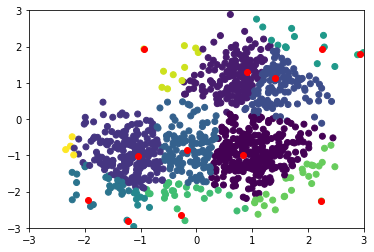

k: 0.75 number of centres: 6


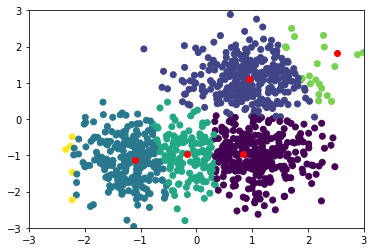

k: 1.0 number of centres: 4


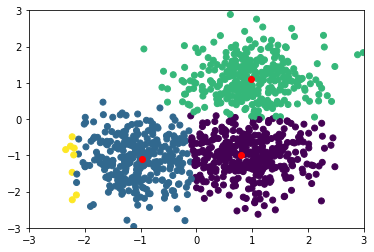

k: 1.25 number of centres: 2


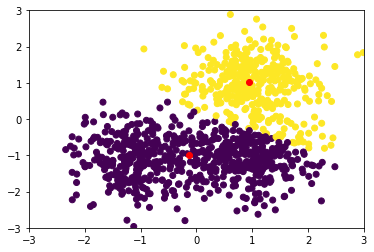

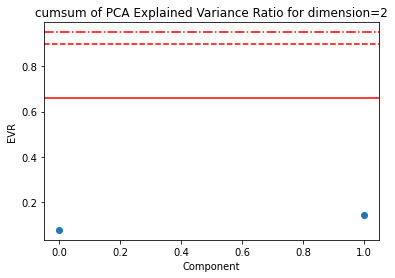

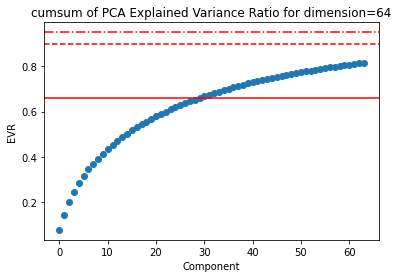

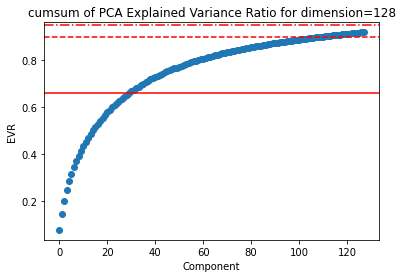

Results for MS on dim=2 (5.43s)
number of centers: 8 - window size: 1
adjusted_rand_score 20.68 %
rand_score 81.86 %

Results for MS on dim=64 (6.53s)
number of centers: 41 - window size: 6.3
adjusted_rand_score 3.22 %
rand_score 48.75 %

Results for MS on dim=128 (18.44s)
number of centers: 13 - window size: 7.5
adjusted_rand_score 0.01 %
rand_score 11.45 %

Results for MS on dim=256 (32.57s)
number of centers: 250 - window size: 7
adjusted_rand_score 6.42 %
rand_score 69.51 %

  clustering_model dim_red_model    d    k       time       ARI        RI
0               MS           PCA    2  1.0   5.429447  0.206825  0.818561
1               MS           PCA   64  6.3   6.529534  0.032176  0.487477
2               MS           PCA  128  7.5  18.437689  0.000055  0.114517
3               MS          NoDR  256  7.0  32.574971  0.064224  0.695134
averages by clustering model:
                      time      ARI        RI
clustering_model                             
MS                15.742

In [13]:
if __name__ == '__main__':
    main()